# Import des packages nécessaires

In [2]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import random
import pylab as pl
from sklearn.metrics import confusion_matrix,accuracy_score
from scipy.cluster.vq import kmeans,vq

# Méthode Bag of Words

In [30]:

# Defining the training path

train_path="dataset/seg_train"
class_names=os.listdir(train_path)

print(class_names)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [31]:
image_paths=[]
image_classes=[]

# Function to List all the filenames in the directory

def img_list(path):
    return (os.path.join(path,f) for f in os.listdir(path))

for training_name in class_names:
    dir_=os.path.join(train_path,training_name)
    class_path=img_list(dir_)
    image_paths+=class_path
    
print(len(image_paths)) # ==> 14034

class_names_to_labels={'buildings':0,'forest':1,'glacier':2,'mountain':3,'sea':4,'street':5}
labels=[]

for image_path in image_paths:
    for class_name in class_names_to_labels.keys():
        if class_name in image_path:
            labels.append(class_names_to_labels[class_name])

image_classes=labels        
            

14034


In [32]:
# Append all the image path and its corresponding labels in a list

D=[]

for i in range(len(image_paths)):
    D.append((image_paths[i],image_classes[i]))

In [33]:
# Shuffle Dataset and split into Training and Testing
total = len(D)
random.shuffle(D)
train = D[:int(0.8 * total)]
test = D[int(0.8 * total):]

image_paths, y_train = zip(*train)
image_paths_test, y_test = zip(*test)

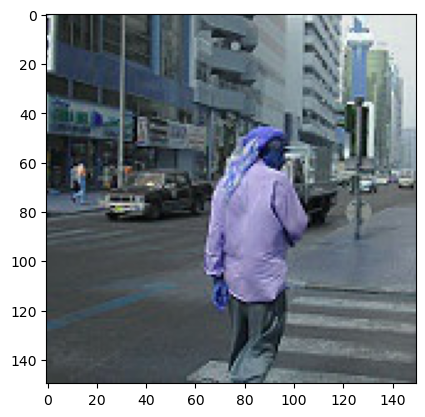

In [35]:
# Feature Extraction using ORB

des_list=[]

orb=cv2.ORB_create()

im=cv2.imread(image_paths[1])

plt.imshow(im) # ==> <matplotlib.image.AxesImage at 0x7f5dd1b37e50>

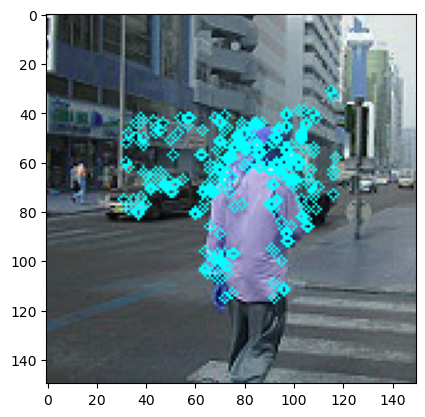

In [36]:
# Function for plotting keypoints

def draw_keypoints(vis, keypoints, color = (0, 255, 255)):
    for kp in keypoints:
            x, y = kp.pt
            plt.imshow(cv2.circle(vis, (int(x), int(y)), 2, color))

# Plotting the keypoints
            
kp = orb.detect(im,None)
kp, des = orb.compute(im, kp)
img=draw_keypoints(im,kp)

In [54]:
# Appending descriptors of the training images in list

for image_pat in image_paths:
    if image_pat is None:
        continue
    im=cv2.imread(image_pat)
    if im is None:
        print(f"Image {image_pat} could not be read")
        continue
    kp=orb.detect(im,None)
    if kp is None:
        print(f"Keypoints could not be detected in {image_pat}")
        continue
    keypoints,descriptor= orb.compute(im, kp)
    if descriptor is None:
        print(f"Descriptor could not be computed in {image_pat}")
        continue
    
    print(f"Image path: {image_pat} - keypoints: {len(keypoints)} - descriptor shape: {descriptor.shape}")
    des_list.append((image_pat,descriptor))
    


Image path: dataset/seg_train\sea\17060.jpg - keypoints: 310 - descriptor shape: (310, 32)
Image path: dataset/seg_train\street\7366.jpg - keypoints: 283 - descriptor shape: (283, 32)
Image path: dataset/seg_train\glacier\3003.jpg - keypoints: 268 - descriptor shape: (268, 32)
Image path: dataset/seg_train\glacier\4576.jpg - keypoints: 274 - descriptor shape: (274, 32)
Image path: dataset/seg_train\mountain\1993.jpg - keypoints: 195 - descriptor shape: (195, 32)
Image path: dataset/seg_train\mountain\669.jpg - keypoints: 273 - descriptor shape: (273, 32)
Image path: dataset/seg_train\buildings\2705.jpg - keypoints: 68 - descriptor shape: (68, 32)
Image path: dataset/seg_train\glacier\4575.jpg - keypoints: 210 - descriptor shape: (210, 32)
Image path: dataset/seg_train\glacier\2510.jpg - keypoints: 106 - descriptor shape: (106, 32)
Image path: dataset/seg_train\sea\5166.jpg - keypoints: 276 - descriptor shape: (276, 32)
Image path: dataset/seg_train\glacier\6282.jpg - keypoints: 310 - d

In [58]:
descriptors= des_list[0][1]
print(descriptors.shape)
print(des_list[0][1].shape)

(310, 32)
(310, 32)


In [65]:

for image_path,descriptor in des_list[1:]:
    if(image_path or descriptor is None):
        print(f"Descriptor could not be computed in {image_path}")
        continue
    print("image_path: ",image_path, " -- descriptor shape: ",descriptor.shape)
    descriptors=np.vstack((descriptors,descriptor))
    
print(descriptors.shape)

descriptors_float=descriptors.astype(float)

Descriptor could not be computed in dataset/seg_train\street\7366.jpg
Descriptor could not be computed in dataset/seg_train\glacier\3003.jpg
Descriptor could not be computed in dataset/seg_train\glacier\4576.jpg
Descriptor could not be computed in dataset/seg_train\mountain\1993.jpg
Descriptor could not be computed in dataset/seg_train\mountain\669.jpg
Descriptor could not be computed in dataset/seg_train\buildings\2705.jpg
Descriptor could not be computed in dataset/seg_train\glacier\4575.jpg
Descriptor could not be computed in dataset/seg_train\glacier\2510.jpg
Descriptor could not be computed in dataset/seg_train\sea\5166.jpg
Descriptor could not be computed in dataset/seg_train\glacier\6282.jpg
Descriptor could not be computed in dataset/seg_train\buildings\1311.jpg
Descriptor could not be computed in dataset/seg_train\forest\3211.jpg
Descriptor could not be computed in dataset/seg_train\buildings\7637.jpg
Descriptor could not be computed in dataset/seg_train\street\15534.jpg
Descr

In [66]:
# Performing K Means clustering on Descriptors
k=200
voc,variance=kmeans(descriptors_float,k,1)

In [23]:

# Creating histogram of training image

im_features=np.zeros((len(image_paths),k),"float32")
for i in range(len(image_paths)):
    words,distance=vq(des_list[i][1],voc)
    for w in words:
        im_features[i][w]+=1

In [24]:
# Applying standardisation on training feature
        
from sklearn.preprocessing import StandardScaler
stdslr=StandardScaler().fit(im_features)
im_features=stdslr.transform(im_features)

In [29]:
print(im_features.shape)
print(len(y_train))

(144, 200)
144


In [27]:
# Creating Classification Model with SVM

from sklearn.svm import SVC
clf=SVC()
clf.fit(im_features,np.array(y_train))

"""
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=80000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)
"""

ValueError: The number of classes has to be greater than one; got 1 class

In [ ]:
# Testing the Classification Model

des_list_test=[]
            
for image_pat in image_paths_test:
    image=cv2.imread(image_pat)
    kp=orb.detect(image,None)
    keypoints_test,descriptor_test= orb.compute(image, kp)
    des_list_test.append((image_pat,descriptor_test))
            
len(image_paths_test) # ==> 40
            
from scipy.cluster.vq import vq
test_features=np.zeros((len(image_paths_test),k),"float32")
for i in range(len(image_paths_test)):
    words,distance=vq(des_list_test[i][1],voc)
    for w in words:
        test_features[i][w]+=1
        
test_features

In [ ]:
test_features=stdslr.transform(test_features)

true_classes=[]
for i in y_test:
    if i==1:
        true_classes.append("Cat")
    else:
        true_classes.append("Dog")

predict_classes=[]
for i in clf.predict(test_features):
    if i==1:
        predict_classes.append("Cat")
    else:
        predict_classes.append("Dog")

print(true_classes)
['Cat', 'Dog', 'Dog', 'Cat', 'Dog', 'Dog', 'Cat', 'Cat', 'Dog', 'Dog', 'Dog', 'Cat', 'Cat', 'Dog', 'Dog', 'Cat', 'Dog', 'Cat', 'Dog', 'Cat', 'Cat', 'Cat', 'Dog', 'Dog', 'Dog', 'Cat', 'Dog', 'Cat', 'Cat', 'Dog', 'Dog', 'Cat', 'Cat', 'Cat', 'Dog', 'Dog', 'Dog', 'Dog', 'Cat', 'Dog']

print(predict_classes)
['Dog', 'Cat', 'Dog', 'Cat', 'Dog', 'Dog', 'Dog', 'Cat', 'Cat', 'Dog', 'Dog', 'Cat', 'Cat', 'Dog', 'Dog', 'Cat', 'Dog', 'Dog', 'Cat', 'Cat', 'Cat', 'Dog', 'Cat', 'Dog', 'Dog', 'Dog', 'Dog', 'Dog', 'Dog', 'Dog', 'Cat', 'Cat', 'Dog', 'Cat', 'Cat', 'Dog', 'Dog', 'Dog', 'Cat', 'Dog']

clf.predict(test_features)

"""
array([0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0])
"""

accuracy=accuracy_score(true_classes,predict_classes)
print(accuracy) # ==> 0.65
            
            
# Matrice de confusion
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(true_classes, predict_classes)